# Random Forest Training for QSO targets selection

**Author:** Edmond Chaussidon (CEA Saclay) (contact: edmond.chaussidon@cea.fr)

This notebook explains how the random forest files (for the targets selection) are generated. To have a brief overview of the QSO targets selection and an interpretability of this selection, see `qso-dr8.ipynb` notebook written for DR8s release (however no major changes are expected with DR9 !)

All the file are written and saved in NERSC : `/global/cfs/cdirs/desi/target/analysis/RF`

**/!\** **WARNING** This notebook had generated files in NERSC !! **PLEASE** change path and savename to don't overwritte data or be sure to keep alive the current files. **/!\**

The training is divided in three parts :
    
    * 1) data_collection : collect data from dr9 (match sdss with dr9)
    * 2) data_preparation : build atributes for RF
    * 3) train_test_RF : training and some tests

**Remark:** The first part is time consumming and already saved in : `/global/cfs/cdirs/desi/target/analysis/RF/`

**UPDATE:** We add quasars from VI in the training!


In [1]:
DIR = '/global/cfs/cdirs/desi/target/analysis/RF/'

from pathlib import Path
path_train = f'{Path().absolute()}/../../py/desitarget/train/'

-------
## 1.1)  data_collection

**WARNING:** This part is time consuming...

**REMARK:** Not necessary to run this section for the training if the files are existing in DIR **/!\** 

In [ ]:
from desitarget.train.data_collection.sweep_meta import sweep_meta

sweep_meta('dr9s', f'{DIR}dr9s_sweep_meta.fits')
sweep_meta('dr9n', f'{DIR}dr9n_sweep_meta.fits')

* Add your version of topcat in my_tractor_extract_batch.py :

    `STILTSCMD = 'java -jar -Xmx4096M /global/homes/e/edmondc/Software/topcat/topcat-full.jar -stilts'`
    
* If you want a version of topcat go [here](`http://www.star.bris.ac.uk/~mbt/topcat/`).


In [ ]:
#from desitarget.train.data_collection.my_tractor_extract_batch import my_tractor_extract_batch

#collect QSO sample
#my_tractor_extract_batch(16, f'{DIR}QSO_DR9s_sdss.fits', 'dr9s', '0,360,-10,30', 'qso', path_train, DIR)

In [ ]:
#collect stars sample
#my_tractor_extract_batch(4, f'{DIR}STARS_DR9s.fits', 'dr9s', '320,345,-1.25,1.25', 'stars', path_train, DIR)

In [ ]:
#collect test sample 
#my_tractor_extract_batch(4, f'{DIR}TEST_DR9s.fits', 'dr9s', '30,45,-5,5', 'test', path_train, DIR)

## 1.2) Add QSOs from VI

    * We match VI quasars with DR9 photometry
    * We add ALL quasars on the catalog (don't check if they are in the test zone --> they will be removed in the next step!)
    * We add VI quasars which are in the test zone into the Test file

In [ ]:
from desitarget.train.data_collection.QSOs_from_VI import extract_qsos_from_vi, sdss_vi_merger

DIR = '/global/cfs/cdirs/desi/target/analysis/RF/'

vi_catalog_list = ['/global/u2/e/edmondc/Scratch/SHARE/QSO_cascade_V1.fits']
output_path = f'{DIR}QSO_DR9s_VI.fits'

extract_qsos_from_vi(vi_catalog_list, output_path)

In [ ]:
from desitarget.train.data_collection.QSOs_from_VI import sdss_vi_merger

file_sdss = f'{DIR}QSO_DR9s_SDSS.fits'
file_VI = f'{DIR}QSO_DR9s_VI.fits'

output = f'{DIR}QSO_DR9s.fits'

test_zones = [[30, 45, -5, 5], [80, 90, -25, -15]]

sdss_vi_merger(file_sdss, file_VI, output, test_zones)

In [ ]:
from desitarget.train.data_collection.QSOs_from_VI import add_qso_vi_test

file_test = f'{DIR}TEST_DR9s.fits'
file_VI = f'{DIR}QSO_DR9s_VI.fits'

output = f'{DIR}TEST_DR9s_final.fits'

test_zones = [[30, 45, -5, 5], [80, 90, -25, -15]]

add_qso_vi_test(file_test, file_VI, output, test_zones)

--------
## 2) data_preparation 

**Remark :** We remove test region from training data in *data_preparation/Code/make_training_samples.py* (it is **hard coding**)  for the region 30<RA<45 & -5<DEC<5. 

**/!\** **Take CARE** if you don't use this region for the test_sample **/!\**

n_STARS initial : 3808094
[INFO] shift photometry for 0 objects
[WARNING] REMOVE FROM THE STARS TRAINING maskbits 1, 5, 6, 7, 10, 12, 13 (IF YOU WANT TO ADD/REMOVE MORE MASKBITS GO HERE)
[INFO] Removing test region...
n_STARS after selection/before normalization : 533741

n_QSO initial : 382256
[INFO] shift photometry for 0 objects


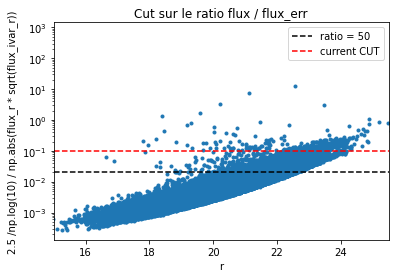

[WARNING] REMOVE FROM THE QSO TRAINING maskbits 1, 5, 6, 7, 10, 12, 13 (IF YOU WANT TO ADD/REMOVE MORE MASKBITS GO HERE)
[INFO] Removing test region...
n_QSO selected in FatStripe82 : 54004
n_QSO selected outside FatStripe82 : 274968
n_QSO after selection : 328972

╔STARS/QSO TABLE══╦═══════════════╦═══════════════════╦═════════════════════════╦═════════════╦═══════════════════╦══════════════╗
║ m_rmag ║ M_rmag ║ n_STARS_drmag ║ n_sel_STARS_drmag ║ n_sel_STARS_drmag_z>3.2 ║ n_QSO_drmag ║ n_QSO_drmag_z>3.2 ║ nw_QSO_drmag ║
╠════════╬════════╬═══════════════╬═══════════════════╬═════════════════════════╬═════════════╬═══════════════════╬══════════════╣
║  17.5  ║  17.7  ║      9315     ║        1115       ║            14           ║     1115    ║         14        ║ 309          ║
╠════════╬════════╬═══════════════╬═══════════════════╬═════════════════════════╬═════════════╬═══════════════════╬══════════════╣
║  17.7  ║  17.9  ║      9858     ║        1692       ║            23          

In [36]:
DIR = '/global/cfs/cdirs/desi/target/analysis/RF/'

from desitarget.train.data_preparation.make_training_samples import make_training_samples

#range in r mag for the training and test sample : 17.5 <--> max_rmag
max_rmag = 23.2

# Need to find a balance between acceptable errors in the measured data and good representativeness of the photometric scattering inherent to QSO.
# (cf mail exchange with Christophe and Nathalie)
# Ratio = QSO_data.FLUX_R * np.sqrt(QSO_data.FLUX_IVAR_R)
# 0.2 ==> ratio=5 | 0.1 ==> ratio=10 | 0.02 ==> ratio=50
QSO_MAX_MAG_ERR_LEVEL = 0.1

#changer nom qso sample for training
make_training_samples(f'{DIR}QSO_DR9s_SDSS.fits', f'{DIR}STARS_DR9s.fits', f'{DIR}QSO_TrainingSample_DR9s.fits', f'{DIR}STARS_TrainingSample_DR9s.fits', f'{DIR}STARS_TrainingSample_Highz_DR9s.fits', max_rmag, QSO_MAX_MAG_ERR_LEVEL)

In [ ]:
from desitarget.train.data_preparation.make_test_sample import make_test_sample

make_test_sample(f'{DIR}TEST_DR9s_final.fits', f'{DIR}TestSample_DR9s.fits', max_rmag=23.0)

------
## 3) train_test_RF


In [8]:
from pathlib import Path
path_train = f'{Path().absolute()}/../../py/desitarget/train/'

DIR = '/global/cfs/cdirs/desi/target/analysis/RF/'

max_rmag = 23.2

print("[WARNING] DO 2 BEFORE 3 !!!")

[WARNING] DO 2 BEFORE 3 !!!


In [9]:
#Pipeline Congifuration (to generate RF with different hyperparameters)
from desitarget.train.train_test_RF.PipelineConfigScript import PipelineConfigScript

fpn_STARS_TrainingSample = f"{DIR}STARS_TrainingSample_DR9s.fits"
fpn_STARS_TrainingSample_Highz = f"{DIR}STARS_TrainingSample_Highz_DR9s.fits"
fpn_QSO_TrainingSample = f"{DIR}QSO_TrainingSample_DR9s.fits"
fpn_TestSample = f"{DIR}TestSample_DR9s.fits"
fpn_QLF = f"{path_train}data_preparation/ROSS4_tabR"

suffixe = '_final_ratio10'
fpn_config = f"{DIR}config{suffixe}.npz"

PipelineConfigScript(fpn_QSO_TrainingSample, fpn_STARS_TrainingSample, fpn_STARS_TrainingSample_Highz, fpn_TestSample, fpn_QLF, fpn_config, max_rmag=max_rmag, suffixe=suffixe)


///**********TS CONFIG SCRIPT**********///
Save : /global/cfs/cdirs/desi/target/analysis/RF/config_final_ratio10.npz


In [28]:
#Random Forest training
from desitarget.train.train_test_RF.train_RF import train_RF

#RF all-z training
train_RF(f'{DIR}config{suffixe}.npz', 'DR9s_LOW', f'{DIR}RFmodel/DR9s_LOW')


///**********TRAIN RF**********///
INFO::TRAIN RF: RELEASE : ('DR9s')
INFO::TRAIN RF: BANDS : ('grzW')
INFO::TRAIN RF: MODEL : ('DR9s_LOW')
INFO::TRAIN RF: HYPERPARAMETERS SPACE :
OrderedDict([('RF:maxDepth',
              [25]),
             ('RF:maxLNodes',
              [850]),
             ('RF:min_zred',
              [[0.0,
                6.0]]),
             ('RF:nTrees',
              [500])])
INFO::TRAIN RF: hyParamSpaceSize : ( 1 )
INFO::TRAIN RF: hyParamSpaceShape : ( [1, 1, 1, 1] )

INFO::TRAIN RF: feature_names : (['g_r', 'r_z', 'g_z', 'g_W1', 'r_W1', 'z_W1', 'g_W2', 'r_W2', 'z_W2', 'W1_W2', 'r'])
INFO::TRAIN RF: n_features : (11)
INFO::TRAIN RF: n_jobs : (20)

INFO::TRAIN RF: STARS Training Sample : ('/global/cfs/cdirs/desi/target/analysis/RF/STARS_TrainingSample_DR9s.fits')
INFO::TRAIN RF: n_STARS : (226401)
INFO::TRAIN RF: QSO Training Sample : ('/global/cfs/cdirs/desi/target/analysis/RF/QSO_TrainingSample_DR9s.fits')
INFO::TRAIN RF: n_QSO (231687)

INFO::TRAIN RF: TR

In [29]:
#RF Highz training
train_RF(f'{DIR}config{suffixe}.npz', 'DR9s_HighZ', f'{DIR}RFmodel/DR9s_HighZ')


///**********TRAIN RF**********///
INFO::TRAIN RF: RELEASE : ('DR9s')
INFO::TRAIN RF: BANDS : ('grzWHighz')
INFO::TRAIN RF: MODEL : ('DR9s_HighZ')
INFO::TRAIN RF: HYPERPARAMETERS SPACE :
OrderedDict([('RF:maxDepth',
              [25]),
             ('RF:maxLNodes',
              [850]),
             ('RF:min_zred',
              [[3.2,
                6.0]]),
             ('RF:nTrees',
              [500])])
INFO::TRAIN RF: hyParamSpaceSize : ( 1 )
INFO::TRAIN RF: hyParamSpaceShape : ( [1, 1, 1, 1] )

INFO::TRAIN RF: feature_names : (['g_r', 'r_z', 'g_z', 'g_W1', 'r_W1', 'z_W1', 'g_W2', 'r_W2', 'z_W2', 'W1_W2', 'r'])
INFO::TRAIN RF: n_features : (11)
INFO::TRAIN RF: n_jobs : (20)

INFO::TRAIN RF: STARS Training Sample : ('/global/cfs/cdirs/desi/target/analysis/RF/STARS_TrainingSample_Highz_DR9s.fits')
INFO::TRAIN RF: n_STARS : (8314)
INFO::TRAIN RF: QSO Training Sample : ('/global/cfs/cdirs/desi/target/analysis/RF/QSO_TrainingSample_DR9s.fits')
INFO::TRAIN RF: n_QSO (231687)

INFO::T

In [10]:
#Sklearn to desitarget format
from desitarget.train.train_test_RF.Convert_to_DESI_RF import convert_and_save_to_desi 

RF_filename_input = f"{DIR}RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz"
RF_filename_output = f"{DIR}RFmodel_desitarget/rf_model_dr9{suffixe}.npz"
convert_and_save_to_desi(RF_filename_input, RF_filename_output)

RF_HighZ_filename_input = f"{DIR}RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz"
RF_HighZ_filename_output = f"{DIR}RFmodel_desitarget/rf_model_dr9_HighZ{suffixe}.npz"
convert_and_save_to_desi(RF_HighZ_filename_input, RF_HighZ_filename_output)

Starting convertion...
File load :  /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio10.pkl.gz
RandomForestClassifier(max_depth=25, max_leaf_nodes=850, n_estimators=500,
                       n_jobs=20) 

Desi format is saved at :  /global/cfs/cdirs/desi/target/analysis/RF/RFmodel_desitarget/rf_model_dr9_final_ratio10.npz 

Starting convertion...
File load :  /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio10.pkl.gz
RandomForestClassifier(max_depth=25, max_leaf_nodes=850, n_estimators=500,
                       n_jobs=20) 

Desi format is saved at :  /global/cfs/cdirs/desi/target/analysis/RF/RFmodel_desitarget/rf_model_dr9_HighZ_final_ratio10.npz 



/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


------------
## 4) Some tests 

    * Plot for completeness, importance feature ect ...
    * enable also to tune the threshold selection :) 

In [ ]:
#plot only for one training

from desitarget.train.train_test_RF.Some_tests import make_some_tests_and_plots

suffixe = '_test_ratio10'

inputFile = f'{DIR}TestSample_DR9s_old.fits'
RF_file = f'{DIR}RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'
RF_Highz_file = f'{DIR}RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'

make_some_tests_and_plots(inputFile, RF_file, RF_Highz_file, rmax=23.0)


############################################
Input file =  /global/cfs/cdirs/desi/target/analysis/RF/TestSample_DR9s.fits
Original size:  3136298
Reduce size:  535947
############################################

Load Random Forest: 
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio10.pkl.gz
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio10.pkl.gz
Random Forest over:  535947  objects

Load Random Forest: 
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio10.pkl.gz
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio10.pkl.gz
Random Forest over:  535947  objects

############################################
R magnitude Elements from Test Sample : 
R_

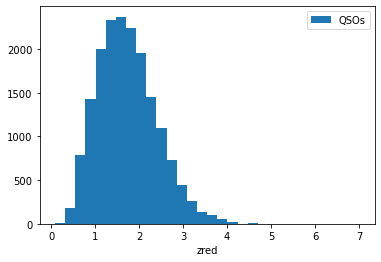


[INFO] CUT1 :  cut = 0.6 - 0.05*np.tanh(r - 20.5) & cut_Highz = 1.0


############################################
density dr9 =  356.63143989431967  deg^-2 completeness dr9 0.9876262912929958
density dr9 Highz =  0.0  deg^-2 completeness dr9 Highz 0.0
density dr9 Total =  356.63143989431967  deg^-2 completeness dr9 Total 0.9876262912929958
############################################


[INFO] CUT2 :  cut = 0.75 - 0.05*np.tanh(r - 21.5) & cut_Highz = 1.0


############################################
density dr9 =  315.57463672391015  deg^-2 completeness dr9 0.9805312748325576
density dr9 Highz =  0.0  deg^-2 completeness dr9 Highz 0.0
density dr9 Total =  315.57463672391015  deg^-2 completeness dr9 Total 0.9805312748325576
############################################



/global/homes/e/edmondc/Software/desitarget/py/desitarget/train/train_test_RF/Some_tests.py:200: RuntimeWarning: invalid value encountered in true_divide
  ratio = y/x
/global/homes/e/edmondc/Software/desitarget/py/desitarget/train/train_test_RF/Some_tests.py:203: RuntimeWarning: invalid value encountered in true_divide
  errors = np.sqrt(y*(x-y)/x**3)


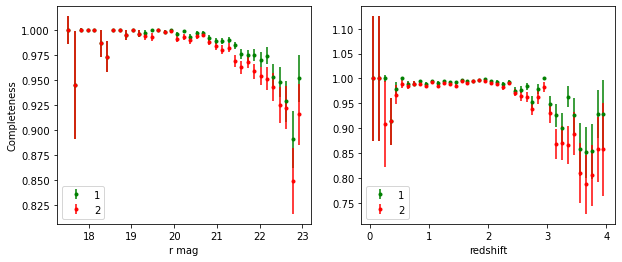

In [6]:
#plot to compare two differents training

from desitarget.train.train_test_RF.Some_tests import make_some_tests_and_plots_2_training

DIR = '/global/cfs/cdirs/desi/target/analysis/RF/'

inputFile = f'{DIR}TestSample_DR9s.fits'

suffixe = '_final_ratio10'
RF_file = f'{DIR}RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'
RF_Highz_file = f'{DIR}RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'
#ut = [0.74, 0.05, 22.5, 0.95]
cut = [0.6, 0.05, 20.5, 1.0]

suffixe = '_final_ratio10'
RF_file_2 = f'{DIR}RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'
RF_Highz_file_2 = f'{DIR}RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'
cut2 = [0.75, 0.05, 21.5, 1.0]

make_some_tests_and_plots_2_training(inputFile, RF_file, RF_Highz_file, RF_file_2, RF_Highz_file_2, cut, cut2, r_mag_max_sel=23.0, surface_vi=True)


############################################
Input file =  /global/cfs/cdirs/desi/target/analysis/RF/TestSample_DR9s_old.fits
Original size:  3135690
Reduce size:  535391
############################################

Load Random Forest: 
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio5.pkl.gz
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio5.pkl.gz
Random Forest over:  535391  objects

Load Random Forest: 
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500.pkl.gz
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500.pkl.gz
Random Forest over:  535391  objects

############################################
R magnitude Elements from Test Sample : 
R_mag max =  22.999986648559

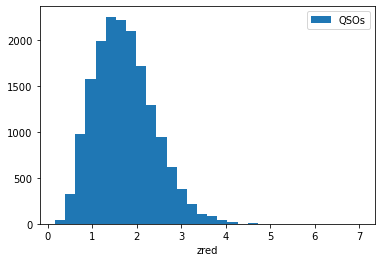


############ NEW #####################

[INFO] FOR NEW :  cut = 0.86 - 0.05*np.tanh(r - 20.5) & cut_Highz = 0.85

density dr9 =  248.89423193629324  deg^-2 completeness dr9 0.9782698553291999  density dr9 QSO>3.0 :  3.853347245384301  (ie)  83.88969521044993 % de l'echantillong de test
density dr9 Highz =  16.386725828987217  deg^-2 completeness dr9 Highz 0.003956303513433717  densisty dr9 Highz QSO>3.0 :  0.10000036103938498  (ie)  2.1770682148040637 % de l'echantillong de test
density dr9 Total =  265.28095776528045  deg^-2 completeness dr9 Total 0.9822261588426336
############################################


########## REFERENCE ############################

[INFO] (WARNING : the test sample is in a contaminated region of DES) so the cut is harder than in des : cut = 0.86 - 0.05*np.tanh(r - 20.5) & cut_Highz = 0.55  

density dr9 =  256.5342595197023  deg^-2 completeness dr9 0.9812813699439031  density dr9 QSO>3.0 :  3.833347173176424  (ie)  83.45428156748912 % de l'echantillong 

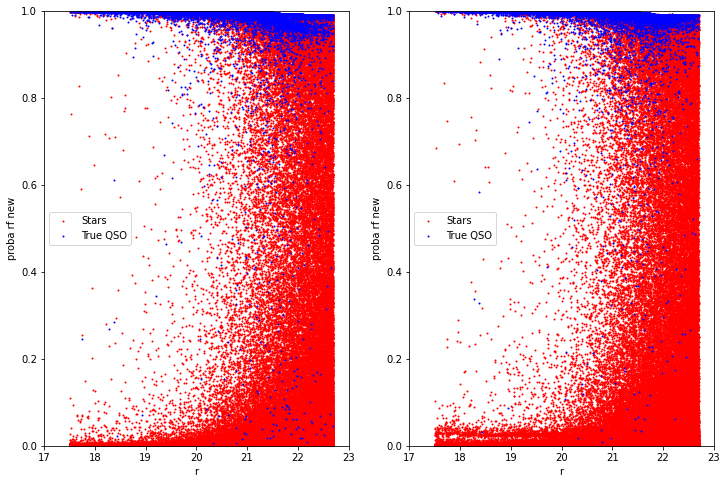

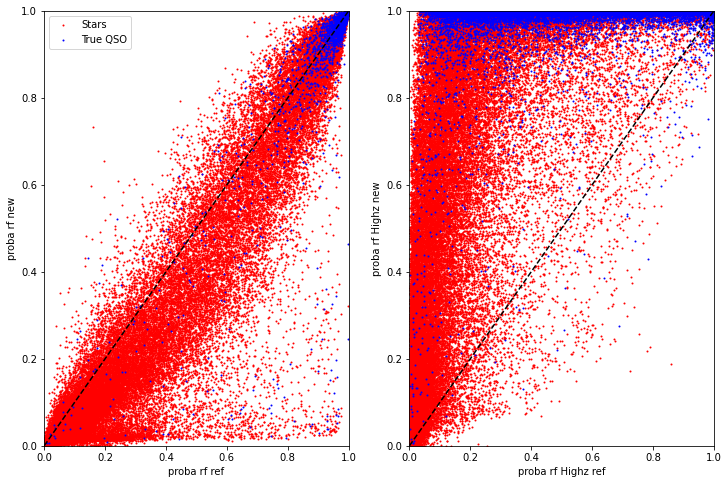

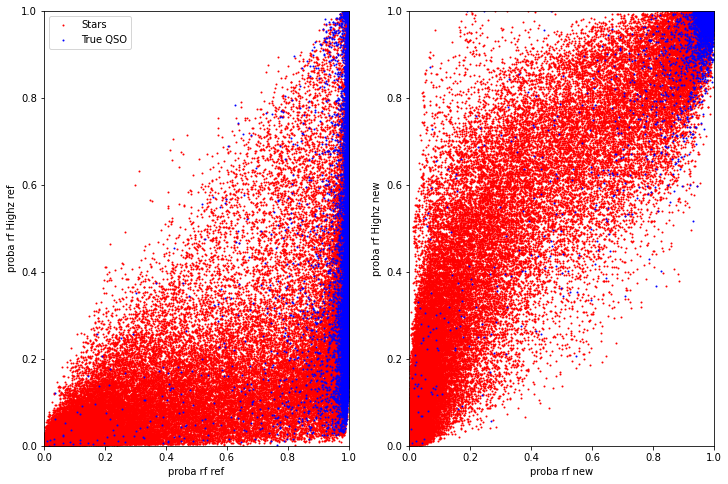

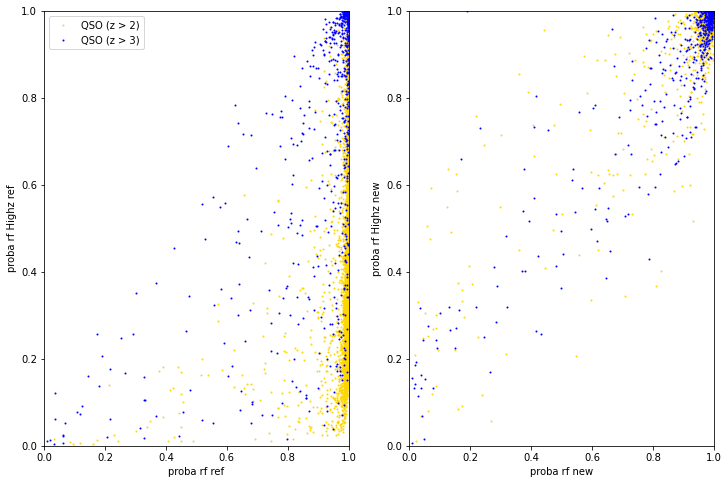

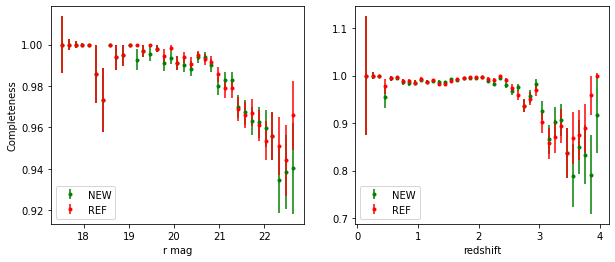

In [35]:
#plot to compare to desitarget

from desitarget.train.train_test_RF.Some_tests import new_training_versus_desitarget

DIR = '/global/cfs/cdirs/desi/target/analysis/RF/'

suffixe = '_final_ratio5'

inputFile = f'{DIR}TestSample_DR9s_old.fits'

RF_file = f'{DIR}RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'
RF_Highz_file = f'{DIR}RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'

#cut = [0.74, 0.05, 22.5, 0.95]
cut = [0.86, 0.05, 20.5, 0.85]


new_training_versus_desitarget(inputFile, RF_file, RF_Highz_file, cut=cut, r_mag_max_sel=22.7, surface_vi=False)


############################################
Input file =  /global/cfs/cdirs/desi/target/analysis/RF/TestSample_DR9s_old.fits
Original size:  3135690
Reduce size:  535391
############################################

Load Random Forest: 
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio10.pkl.gz
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500_final_ratio10.pkl.gz
Random Forest over:  535391  objects

Load Random Forest: 
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500.pkl.gz
    * /global/cfs/cdirs/desi/target/analysis/RF/RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500.pkl.gz
Random Forest over:  535391  objects

############################################
R magnitude Elements from Test Sample : 
R_mag max =  22.9999866485

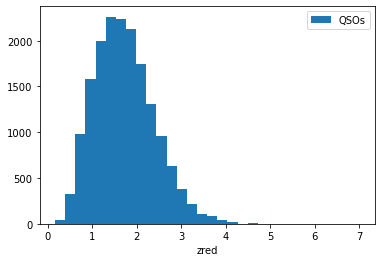


############ NEW #####################

[INFO] FOR NEW :  cut = 0.73 - 0.05*np.tanh(r - 22.5) & cut_Highz = 0.96

density dr9 =  311.46112449326847  deg^-2 completeness dr9 0.9824170671668034  density dr9 QSO>3.0 :  4.020014513783276  (ie)  87.26483357452966 % de l'echantillong de test
density dr9 Highz =  1.2066710232085787  deg^-2 completeness dr9 Highz 0.00023443910444262102  densisty dr9 Highz QSO>3.0 :  0.013333381471917998  (ie)  0.2894356005788712 % de l'echantillong de test
density dr9 Total =  312.66779551647704  deg^-2 completeness dr9 Total 0.9826515062712461
############################################


########## REFERENCE ############################

[INFO] (WARNING : the test sample is in a contaminated region of DES) so the cut is harder than in des : cut = 0.86 - 0.05*np.tanh(r - 20.5) & cut_Highz = 0.55  

density dr9 =  305.34776908839405  deg^-2 completeness dr9 0.9807173836595944  density dr9 QSO>3.0 :  3.8400138639123833  (ie)  83.3574529667149 % de l'echantill

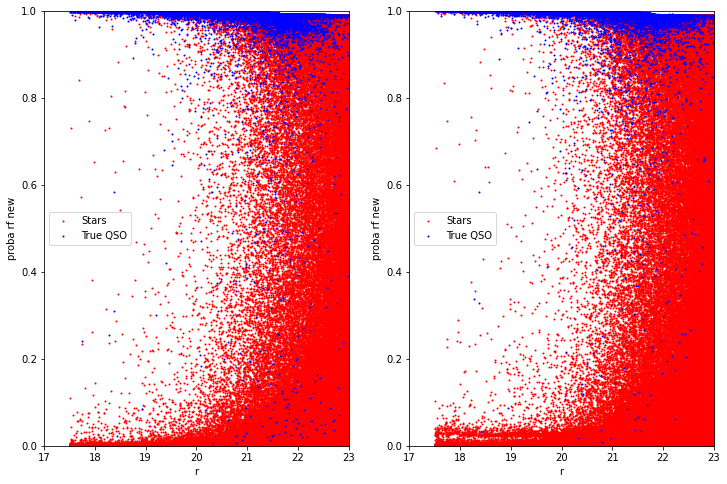

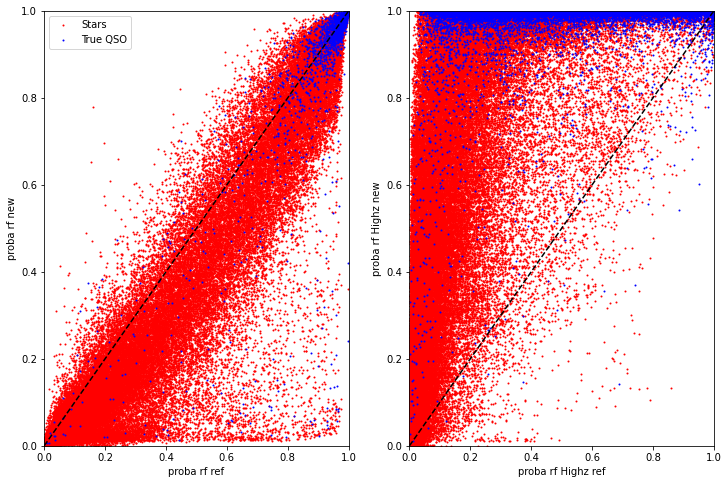

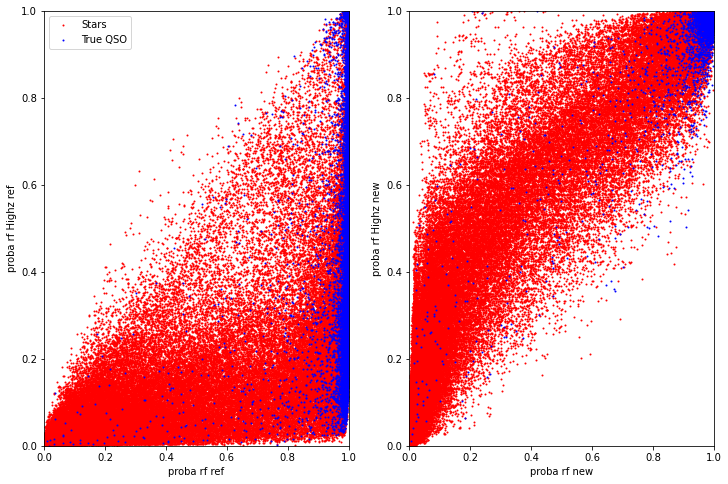

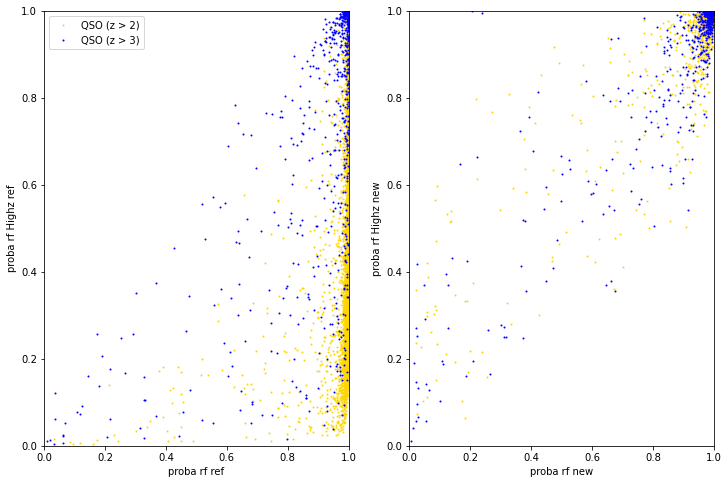

/global/homes/e/edmondc/Software/desitarget/py/desitarget/train/train_test_RF/Some_tests.py:200: RuntimeWarning: invalid value encountered in true_divide
  ratio = y/x
/global/homes/e/edmondc/Software/desitarget/py/desitarget/train/train_test_RF/Some_tests.py:203: RuntimeWarning: invalid value encountered in true_divide
  errors = np.sqrt(y*(x-y)/x**3)


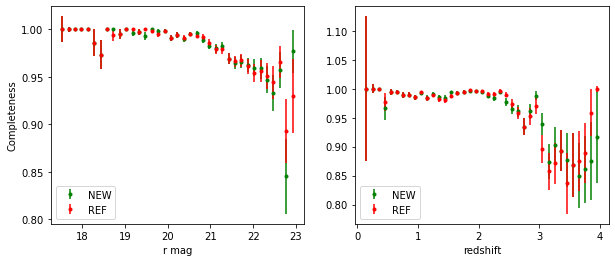

In [21]:
#plot to compare to desitarget

from desitarget.train.train_test_RF.Some_tests import new_training_versus_desitarget

DIR = '/global/cfs/cdirs/desi/target/analysis/RF/'

suffixe = '_final_ratio10'

inputFile = f'{DIR}TestSample_DR9s_old.fits'

RF_file = f'{DIR}RFmodel/DR9s_LOW/model_DR9s_LOW_z[0.0, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'
RF_Highz_file = f'{DIR}RFmodel/DR9s_HighZ/model_DR9s_HighZ_z[3.2, 6.0]_MDepth25_MLNodes850_nTrees500{suffixe}.pkl.gz'

cut = [0.73, 0.05, 22.5, 0.96]

new_training_versus_desitarget(inputFile, RF_file, RF_Highz_file, cut=cut, r_mag_max_sel=23.0, surface_vi=False)